In [1]:
import umap
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
IDs=[]
X=[]
with open("./iain_label_test.csv","r") as f:
    s=f.readline()
    while True:
        s=f.readline()
        if not s:
            break 
        ID = s.split(",")[0]
        x  = s[len(ID)+3:-3].split(",")
        X.append(np.array(x))
X = np.vstack(X)
print(X.shape)
        
        
    

(503, 9)


In [3]:
Xn = normalize( X, norm='l2', axis=0 )
nclass = 2

#
#  Umap is somewhat usable for easy case (1),
# but does not work so well for few labels (2)
#which_labels = 1
which_labels = 2

if which_labels==1: # easy case
    # alt. label everything 1/3 class 0, 1/3 class 1, 1/3 unlabeled(-1)
    target = np.array(np.random.randint(0,3,X.shape[0]))[:,None]
if which_labels==2: # very few labels, different class cardinalities
    target = np.full((X.shape[0],1), -1, dtype=np.int8)
    target[-10:-3] = 0
    target[-3:] = 1

print("target shape ",target.shape)
print("target[-20:].flatten()", target[-20:].flatten())

# try defaults - like tutorial
# Euclidean embedding
Euc_map = umap.UMAP(random_state=42,
                    metric='euclidean',
                    #target_weight = 0.9,
                    n_neighbors=9,
                    #target_n_neighbors=3,
                    #verbose=True
   ).fit( Xn ) #, y=target )
Cat_map = umap.UMAP(random_state=42,
                    metric='categorical',
                    n_neighbors=9 # horrible (and slow) int(X.shape[0]/2),
             ).fit( target )

#      print("UMAP ends SemiSupervised")


target shape  (503, 1)
target[-20:].flatten() [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0  0  1  1  1]


/home/ml/kruus/wrk/umap-constraint/umap/umap_.py:1859: UserWarning: gradient function is not yet implemented for categorical distance metric; inverse_transform will be unavailable
  warn(


In [4]:
print(Euc_map.embedding_)
print(Cat_map.embedding_)

[[ 8.486288   7.047694 ]
 [ 8.075322   7.6447473]
 [10.841368   6.0919795]
 ...
 [10.804643   9.201239 ]
 [10.643676   9.014599 ]
 [ 8.369657   6.538517 ]]
[[ 6.0149493   3.1888115 ]
 [ 1.8559664   0.24297409]
 [ 3.141823   -0.156921  ]
 ...
 [ 1.8636824   3.203845  ]
 [ 1.9072455   3.1536243 ]
 [ 1.9359933   3.230079  ]]


In [5]:
tcolor = -0.5 + 12*((nclass-(target[:,0]+1))/(nclass+1))
print(tcolor.shape)
# also color nearest neighbors of Euc_map graph
#print(Euc_map.graph_)
labeled = np.where(target[:,0] >= 0)[0]
print(labeled)
nn = np.zeros(Xn.shape[0], dtype=np.int8)
for i,e in enumerate(Euc_map.graph_):
    li = target[i]
    if li >= 0 and not li in labeled:
        #print(li, e.__dict__)
        # {'_shape': (1, 503), 'maxprint': 50,
        #  'indices': array([119, 122, 129, 200, 215, 307, 410, 466, 478], dtype=int32),
        #  'indptr': array([0, 9], dtype=int32),
        #  'data': array([1.        , 0.15910478, 0.20577571, 0.24530005, 0.691576  ,
        #                 0.24919847, 0.20021832, 0.40386337, 0.30138102], dtype=float32)}
        #print(li, i, e.indices, e.data)
        # knn of i are e.indices
        nn[ e.indices ] = 1
tcolor += nn
print(tcolor[-20:])

(503,)
[493 494 495 496 497 498 499 500 501 502]
[ 7.5  7.5  8.5  7.5  7.5  7.5  7.5  7.5  7.5  7.5  3.5  3.5  3.5  3.5
  4.5  3.5  3.5  0.5  0.5 -0.5]


[[10.804643  9.201239]
 [10.643676  9.014599]
 [ 8.369657  6.538517]]


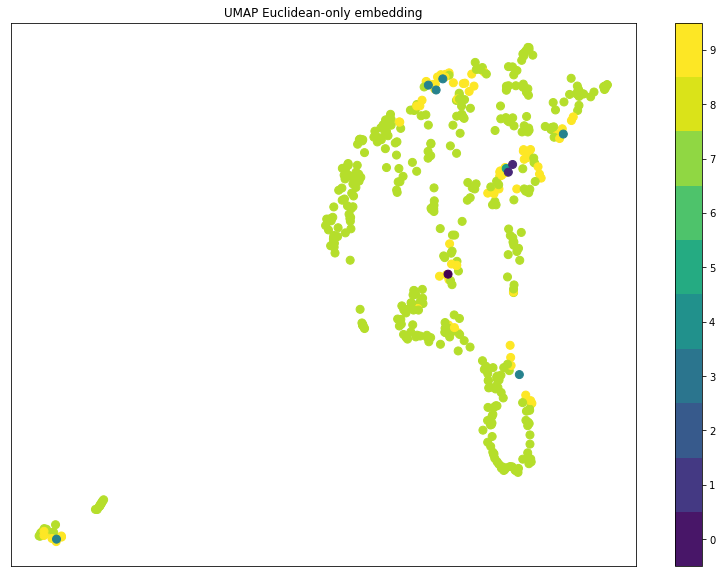

In [6]:
print(Euc_map.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*Euc_map.embedding_.T, s=64.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP Euclidean-only embedding');

Now with so few categorical labels, *everything* will essentially have distance 1.0
to everything else.  Also if class oridinalities differ widely, there might be
trouble in finding a decent knn setting.

The unfortunate consequence is that same-labels should cluster, most of the *Cat_map* connectivity is just "random noise".  I worry that this noise will *infect* the combined
graphs, later on!

[[1.8636824 3.203845 ]
 [1.9072455 3.1536243]
 [1.9359933 3.230079 ]]


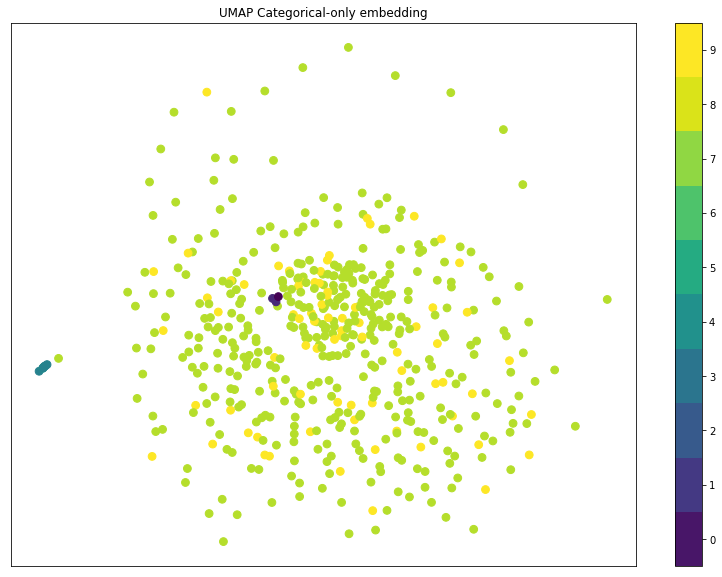

In [7]:
print(Cat_map.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*Cat_map.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP Categorical-only embedding');


### Combining the two umap embeddings
This can be done in a variety of ways.

The default method is *intersection* of the two connectivity graphs.
This means edges that are present in BOTH graphs get used.
So if the Categorical labels are not within 9 knn of the Euclidean embedding,
they essentially do nothing.

You can see [umap examples of composing models](https://umap-learn.readthedocs.io/en/latest/composing_models.html) where the 'diamonds' dataset
is most similar -- there are continuous variables like price, that can be combined
with several ordinal classes for cut, grade, ...

Let's see this in action for this toy problem.

[[ 0.87294436  9.983436  ]
 [ 0.68895036 10.        ]
 [ 0.65880144  8.963791  ]]


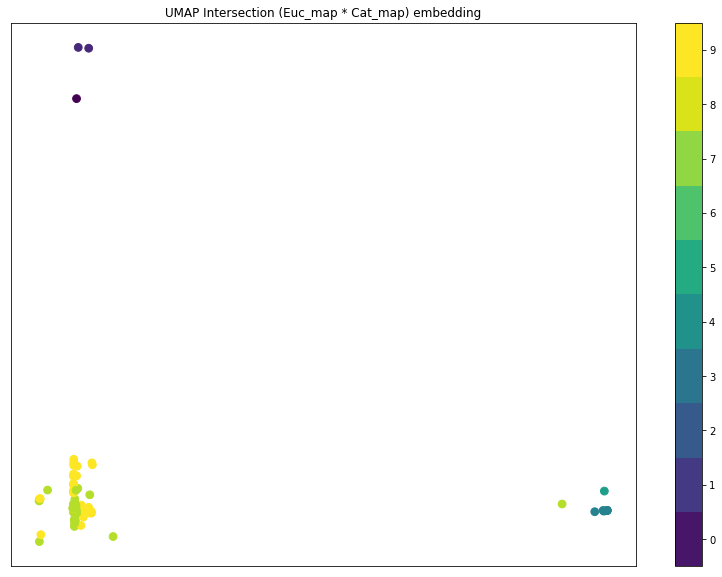

In [8]:
intersection_mapper = Euc_map * Cat_map  # *, +, - for intersection, union, difference
#
print(intersection_mapper.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*intersection_mapper.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP Intersection (Euc_map * Cat_map) embedding');
#

OK, that wasn't as bad as I expected.  Maybe adjusting Euc knn can help?

So how about union?  Roughly, edges in either graph get used in the result.

[[ 2.0360239   9.520207  ]
 [ 0.8419887   9.906245  ]
 [ 0.84065366 10.        ]]


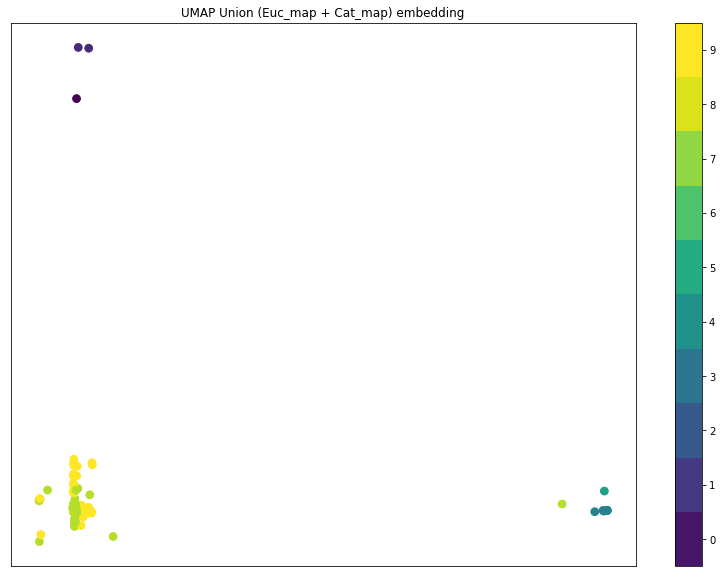

In [9]:
union_mapper = Euc_map + Cat_map  # *, +, - for intersection, union, difference
#
print(union_mapper.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*intersection_mapper.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP Union (Euc_map + Cat_map) embedding');
#
if False:
    diff_mapper = Euc_map - Cat_map  # *, +, - for intersection, union, difference
    #
    print(diff_mapper.embedding_[-3:])
    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.scatter(*intersection_mapper.embedding_.T, s=10.0, c=target*100.0, cmap='prism', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    #cbar.set_ticklabels(classes)
    plt.title('UMAP Difference (Euc_map - Cat_map) embedding');
#

So not much difference.  Intersection does cluster, but really the weighting
between Euclidean and Categorical is not so great.

Looking into the '\*' intersection operator  (method *\_\_mul\_\_*) it's basically
runs *general_simplicial_set_intersection* (with default weight 0.5) and then
fixes up the resulting graph.   It's a bit complicated to do by hand.  So I
added a weight parameter to a new *mul\_helper* version of *\_\_mul\_\_*, that
takes an option *weight* parameter to pass into the general intersection.

[[ 2.0360239   9.520207  ]
 [ 0.8419887   9.906245  ]
 [ 0.84065366 10.        ]]


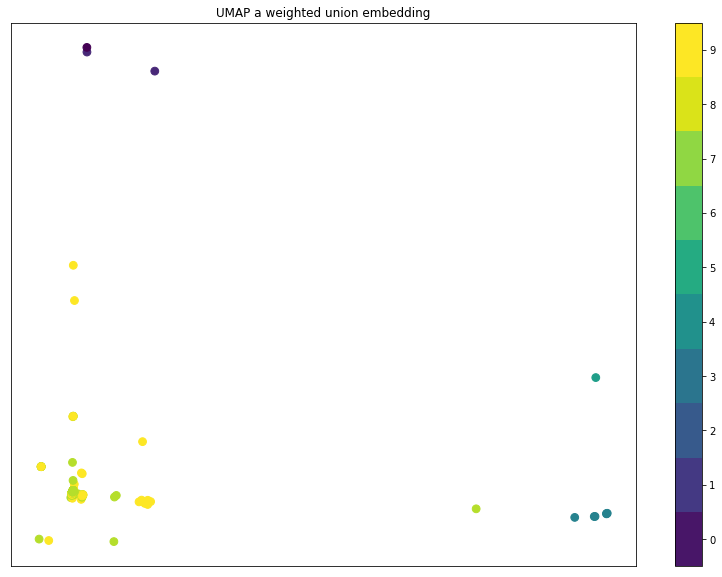

In [10]:
if which_labels==1:
    uw_map = Euc_map.__add__(Cat_map, weight=1)  # local modification of graph combiners to also accept a weight
if which_labels==2:
    uw_map = Euc_map.__add__(Cat_map, weight=0.999)  # local modification of graph combiners to also accept a weight
# There is no effect noticable from combining the weight.
# With so many unlabelled data, the categorical graph pushes almost everything unlabelled to "far".
#
print(uw_map.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*uw_map.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP a weighted union embedding');
#

intersect weight 0.43
[[0.98336244 0.        ]
 [0.73346984 0.0249288 ]
 [0.7073248  0.07689793]]


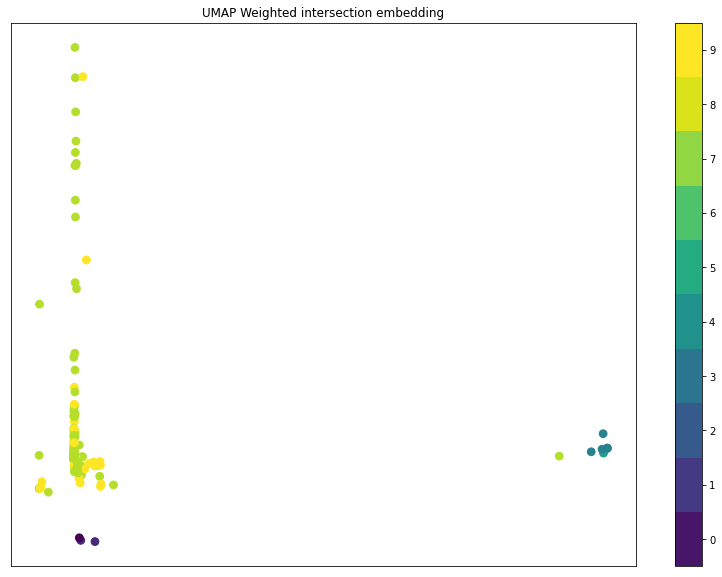

In [11]:
if which_labels==1:
    iw_map = Euc_map.__mul__(Cat_map, weight=0.42)  # local modification of graph combiners to also accept a weight
if which_labels==2:
    iw_map = Euc_map.__mul__(Cat_map, weight=0.43)  # local modification of graph combiners to also accept a weight
# There is no effect noticable from combining the weight.
# With so many unlabelled data, the categorical graph pushes almost everything unlabelled to "far".
#
print(iw_map.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*iw_map.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP Weighted intersection embedding');
#

[[-1.6281228  2.6112626]
 [-1.4974228  2.593717 ]
 [ 1.5630563  4.1019025]]


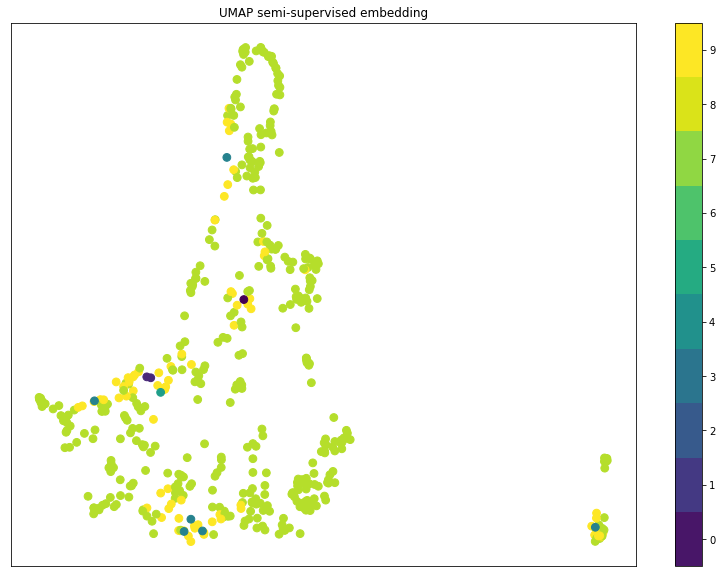

In [12]:
if which_labels==1:
    tw = 1.1
if which_labels==2:
    # there is NO GOOD VALUE for the umap built-in to get clusters
    tw = 0.99

u_map = umap.UMAP(random_state=42,
                    metric='euclidean',
                    n_neighbors=9,
                    target_metric='categorical',
                    target_weight = tw,
                    target_n_neighbors=9,
                    #verbose=True
   ).fit( Xn, y=target )
print(u_map.embedding_[-3:])
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*u_map.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('UMAP semi-supervised embedding');
#

So the UMAP result looks *the same*, and "washes out" too much of the Euclidean graph. There is almost
no effect from playing with n_neighbors, target_n_neighbors, or target_weight.

### OK, so now for something different.
A custom metric can be constructed as follows.

1. append a one-hot class vector to X dimensions
    - if no label, append a zero vector
    - if label, set value in that dim to LBL (default 1.0)
2. now euclidean metric can weight euclidean and categorical data *before* UMAP
   constructs its knn graph.
    - a *high LBL* value means the label data is effectively *more important*.


In [13]:
print("Xn.shape",Xn.shape)
print("nclasses",nclass)
xxshape = (Xn.shape[0], Xn.shape[1]+nclass)
print("xxshape",xxshape)
Xx = np.zeros( xxshape, dtype=np.float64)
print("Xx.shape",Xx.shape)
Xx[:,0:Xn.shape[1]] = Xn
print("target shape",target.shape)

def xxlabel():
    global LBL
    global Xx
    for i in range(target.shape[0]):
        #print(target[i,0])
        lbl = target[i,0]
        if lbl>=0: # i.e one of {0, ..., nclass-1}
            Xx[i, Xn.shape[1]+lbl] = LBL

LBL = 1.11111111111
xxlabel()
print("Xx[-4:]",Xx[-4:])

Xn.shape (503, 9)
nclasses 2
xxshape (503, 11)
Xx.shape (503, 11)
target shape (503, 1)
Xx[-4:] [[ 0.06397849 -0.04973055 -0.04532789  0.06375635 -0.05004528 -0.04351736
   0.06362884 -0.04823032 -0.04346878  1.11111111  0.        ]
 [ 0.03590461 -0.04039909 -0.06526878  0.03688418 -0.03673174 -0.05848837
   0.03743605 -0.03663286 -0.05665784  0.          1.11111111]
 [ 0.0398587  -0.05990358 -0.05975404  0.04144559  0.         -0.06034961
   0.04208047 -0.06458705 -0.06018497  0.          1.11111111]
 [ 0.0385889  -0.03706788 -0.02523662  0.03783949 -0.04618027 -0.02091528
   0.03740536 -0.04807149 -0.01942501  0.          1.11111111]]


** Embed using "extra-dims"
*Xn* has normalized item vectors.
First we have extended dimensionality adding *nclass* zeros.
Then if we had label C, we set the C'th added zero to a big value *LBL*.

A big *LBL* puts same-class items *very far* from all other points, and
close (original euclidean distance) to all same-class points.

Distances between unlabeled items also retain their original euclidean distance;
i.e. *zero in all extra-dims*.

- **Distances from a labeled to other-label will tend to be higher than distances to unlabelled.**
- In principle, it might be nicer to not add *additional labeled-class repulsions*
- But actually you might like labeled-clusters to feel some repulsion!

Let's see how this works out:

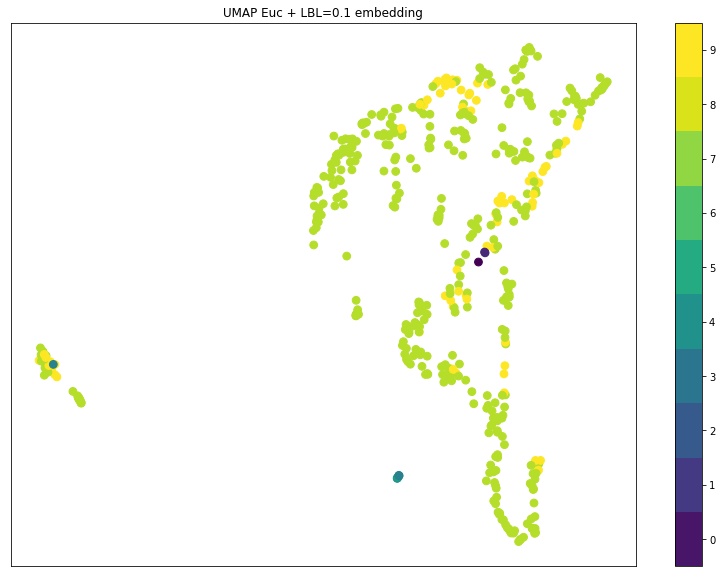

In [14]:
LBL = 0.1  # very tiny clustering one-hot dims -- not enough to force clusters
xxlabel()
# Euclidean embedding of Xx
xxmap = umap.UMAP(random_state=42,
                  metric='euclidean',
                  n_neighbors=9,
                 ).fit( Xx )
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*xxmap.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title(f'UMAP Euc + {LBL=} embedding');
#

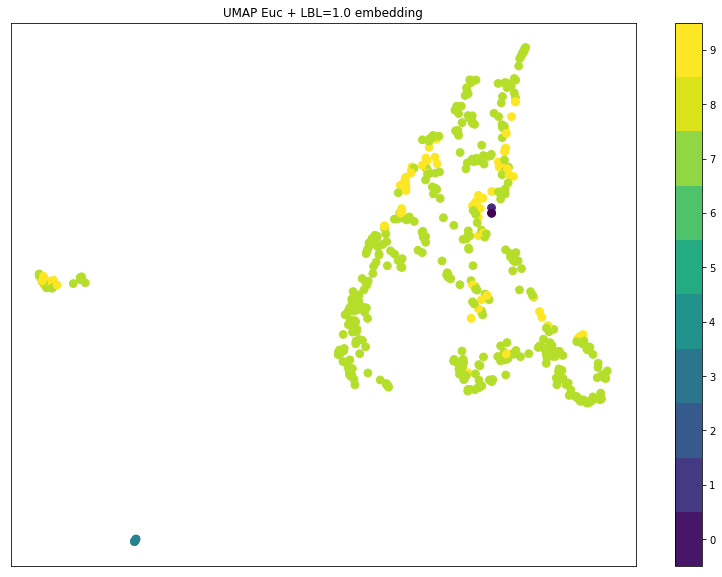

In [15]:
LBL = 1.0  # since Xn was normalized, even 1.0 is enough to cluster well
xxlabel()
xxmap = umap.UMAP(random_state=42,
                  metric='euclidean',
                  n_neighbors=9,
                 ).fit( Xx )
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*xxmap.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title(f'UMAP Euc + {LBL=} embedding');
#

So extra-dims LBL=1.0 has created clusters, but colors of the Euclidean
knn indicate they haven't moved at all.  So the Euclidean info seems not
to be smoothly applied ??  (look at average movement of each point to
get numbers, perhaps matching the positions of all unlabeled points to
get significant numbers)

### Extra-dims view
What we are doing is embedding a feature space into a higher dimension, such
that Euclidean distance (say) naturally gives us useful distances.  Note that
neural networks usually do this already.  They use nonlinear functions to
map into higher-dimensional spaces so that (ex.) separating planes become
findable, for classification tasks.  Kernel methods also embed features into
higher dimensions.

This *extra-dims* approach might also be called "basis expansion".

The one-hot way is a particularly simple (single adjustable scalar)
embedding.  We can add more scale parameters per class to get other
simple embeddings that might help subsequent visualization tasks.

In other cases, it might be more useful to "learn" the *extra-dims* features
using nonlinear functions, such as some neural networks.
Original neural features</BR>
$X \in R^n \rightarrow net_d(X,H) \rightarrow (X,X') \in R^n \otimes R^d$</BR>
where H is some human info (ex. cluster info, drag info) and X' has used
human info H to produce $d$ additional feature dimensions...

In more generality, perhaps $n$ has noise features and a more general transform</BR>
$X \in R^n \rightarrow net_h(X,H) \rightarrow X_h \in R^h$</BR>
can be targeted, for some smaller dimension $h < n+d$.
If $d=0$ the approach is often called *metric learning* (especially if the mapping
is just $R^n \rightarrow R^n$ with a square-matrix multiply)

### Better "extra-dim" mod
The all-zeros *special treatment for unlabelled* has the bad feature of
different minimal distance between unlabeled-unlabeled and unlabeled-labeled
points.

A better view is that we have a *partition* of points, with one of the clusters
being "all unlabeled points".

So with 2 labels and 1 unlabelled cluster, we add 3 *one-hot* style dims instead
of two.   This is probably a pretty minor effect.

### In more generality.
Every partition element can embed into an *arbitrary* number of extra-dims,
at an arbitrary position.  For example, you could embed cluster centers into
always 2 extra-dims, at positions reflecting visualization goals, or perhaps
some idea of cluster-cluster distances.

xpvals [-1  0  1]
Xp_.shape (503, 12)
Xp[:2] [[ 0.03610782 -0.05203247 -0.02705673  0.0402917  -0.04848471 -0.03007599
   0.04136899 -0.04476592 -0.03094777  0.          0.          0.        ]
 [ 0.02618266 -0.03975392 -0.0259992   0.02762123 -0.05205721 -0.02699193
   0.02799251 -0.04927015 -0.02646051  0.          0.          0.        ]]
Xp[-4:] [[ 0.06397849 -0.04973055 -0.04532789  0.06375635 -0.05004528 -0.04351736
   0.06362884 -0.04823032 -0.04346878  0.          1.          0.        ]
 [ 0.03590461 -0.04039909 -0.06526878  0.03688418 -0.03673174 -0.05848837
   0.03743605 -0.03663286 -0.05665784  0.          0.          1.        ]
 [ 0.0398587  -0.05990358 -0.05975404  0.04144559  0.         -0.06034961
   0.04208047 -0.06458705 -0.06018497  0.          0.          1.        ]
 [ 0.0385889  -0.03706788 -0.02523662  0.03783949 -0.04618027 -0.02091528
   0.03740536 -0.04807149 -0.01942501  0.          0.          1.        ]]


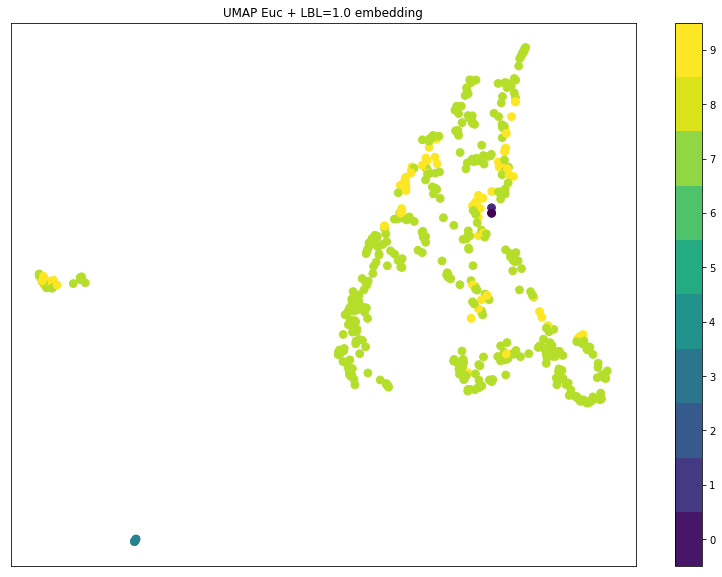

In [16]:
# Extra-dim view using PARTITION
# unlabeled becomes just another class label

def onehot_dims(Xn, target, scalar):
    """
    Expand last (feature) dimension of Xn by some number of distinct values in target.
    
    Distinct target values (sorted) imply which extra-dims value gets changed from 0 to scale.
    """
    xpvals = np.unique(target)         # partition values (from all labels, sorted)
    xpdims = len(xpvals)
    print("xpvals",xpvals)
    #print("xpdims",xpdims)
    z_ = np.zeros(Xn.shape[:-1] +  (xpdims,), dtype=np.float32)
    #print("z_.shape",z_.shape)
    Xp_ = np.append(Xn,z_,axis=Xn.ndim-1)
    print("Xp_.shape",Xp_.shape)
    for i in range(target.shape[0]):
        #print(target[i,0])
        lbl = target[i,0]
        lbldim = np.where(xpvals==lbl)[0][0]  # where is first xpvals==lbl? i.e. "the one-hot dim"
        #print("lbl",lbl, "lbldim",lbldim)
        if lbl>=0: # i.e one of {0, ..., nclass-1}
            Xp_[i, Xn.shape[-1] + lbldim] = scalar
    return Xp_

Xp = onehot_dims(Xn, target, 1.0)
print("Xp[:2]",Xp[:2])
print("Xp[-4:]",Xp[-4:])
xpmap = umap.UMAP(random_state=42,
                  metric='euclidean',
                  n_neighbors=9,
                 ).fit( Xx )
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*xpmap.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title(f'UMAP Euc + {LBL=} embedding');
#

GOOD, using <tt>onehot_dims(Xn,target,1.0)</tt> to add extra-dims is visually
indistinguisable (in this example) from the original unlabeled-zero-vector approach.

#### metric='precomputed'
Here we provide the full distance matrix as input.  This allows us to
scale exactly what we want by exactly how much we want.

- Distances un-un, cl-un, cl-cl' (no change)
- Distances cl-cl --> multiply by scale < 1.0 (known-same-class move closer)

One flaw here is that we destroy having a metric!
i.e. we are quite likely to destroy triangle inequality!

Algorithms to restore triangle inequality offer benefits over the *extra-dims*
approach, though.  In fixing up all points NOT endpoints of a topological worm-hole,
One might (try to) find solutions that restrict pairwise distance mods to within some
small are around wormhole ends.  So pairwise distance matrix elements of "far"
points remain 100% identical.

Here we add the wormholes and DO NOT modify other points to re-establish having
a real *metric*

In [17]:
#t1d = target[:,0]
#print("t1d",t1d[-20:])
#labeled = np.where( t1d>=0 )
labeled = np.where( target[:,0]>=0 )[0] # nb [0]
print("labeled:", labeled)
print(len(labeled))
print(labeled.size)

labeled: [493 494 495 496 497 498 499 500 501 502]
10
10


d 493 493 = 0.0 * 0.0001
d 493 494 = 0.1744269651599003 * 0.0001
d 493 495 = 0.0970127453172554 * 0.0001
d 493 496 = 0.02804247273980758 * 0.0001
d 493 497 = 0.039919805200000824 * 0.0001
d 493 498 = 0.029865856240860165 * 0.0001
d 493 499 = 0.09252971844006364 * 0.0001
d 494 493 = 0.1744269651599003 * 0.0001
d 494 494 = 0.0 * 0.0001
d 494 495 = 0.22321543543719607 * 0.0001
d 494 496 = 0.16388444215173004 * 0.0001
d 494 497 = 0.18191247827201157 * 0.0001
d 494 498 = 0.17545575739442673 * 0.0001
d 494 499 = 0.2048148993537419 * 0.0001
d 495 493 = 0.0970127453172554 * 0.0001
d 495 494 = 0.22321543543719607 * 0.0001
d 495 495 = 0.0 * 0.0001
d 495 496 = 0.10948526573953742 * 0.0001
d 495 497 = 0.061749669396660885 * 0.0001
d 495 498 = 0.09644743955342583 * 0.0001
d 495 499 = 0.03754187227259768 * 0.0001
d 496 493 = 0.02804247273980758 * 0.0001
d 496 494 = 0.16388444215173004 * 0.0001
d 496 495 = 0.10948526573953742 * 0.0001
d 496 496 = 0.0 * 0.0001
d 496 497 = 0.0525168839300958 * 0.0001
d

/home/ml/kruus/wrk/umap-constraint/umap/umap_.py:1837: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


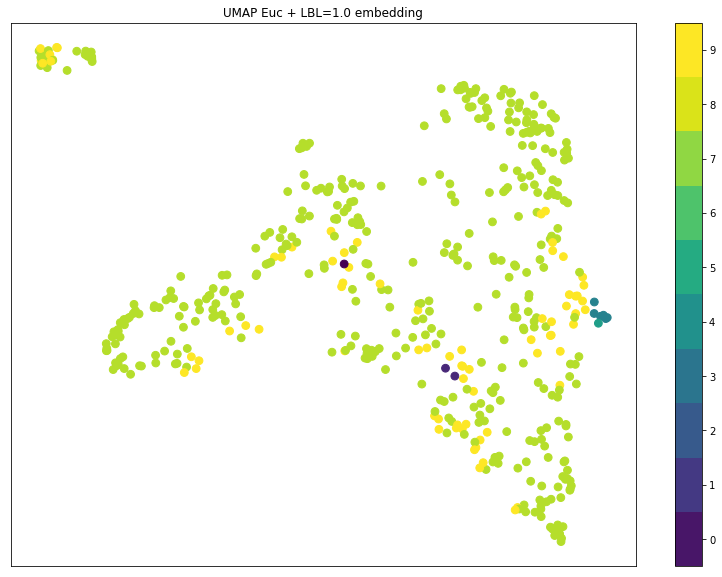

In [18]:
import sklearn
pc = sklearn.metrics.pairwise_distances(Xn)
labeled = np.where( target[:,0]>=0 )[0]
def precomp(Xn, target, labeled, scale_same=0.1):
    """ Naive distance matrix with ONLY modification at the wormholes. """
    pc = sklearn.metrics.pairwise_distances(Xn)
    for i in range(labeled.size):
        li = labeled[i]
        ti = target[li,0]
        for j in range(labeled.size):
            lj = labeled[j]
            tj = target[lj,0]
            if ti == tj:
                print("d",li,lj,"=",pc[li,lj],"*",scale_same)
                pc[li,lj] *= scale_same
    return pc
#
pc = precomp(Xn, target, labeled, scale_same=1e-4)
print("pc[0:4,0:4]",pc[0:4,0:4])
print("pc[-4:,-4:]",pc[-4:,-4:])

# default set_op_mix_ratio is 1.0 ~ UNION fuzzy combination
xpmap = umap.UMAP(random_state=42,
                  metric='precomputed',
                  n_neighbors=30,
                 ).fit( pc )
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*xpmap.embedding_.T, s=60.0, c=tcolor, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title(f'UMAP Euc + {LBL=} embedding');
#

OK. naive precomputed sucks.

# TODO
- label-propagation from unlabeled to labeled extra-dims can
  be done using some tunable distance weighting.
    - Consider labeled neighbors $l$ within neighborhood $\mathcal{N}(u)$
      of an unlabeled point $u$. Nonzero feature $f_u[n+1]>0$ can be moved
      into label dimensions $f_u[n+1+l]$, weighted by the Euclidean u-l
      distance (perhaps $\exp(-\lambda d_{\mathrm{Euc}}(u,l))$)
    - Equiv. view: *before* adding the extra-dims, assign each unlabeled
      point a *label vector* $w_{ul}(u\;\mathrm{of\;class}\;l) \ni \sum(w_{ul})=1$.
      Then modify one-hot to assign extra-dims via
      $scale\cdot w_{ul}^{p} / \sum(w_{ul}^p)$.
- investigate human clusters using exactly 2 extra-dims
    - can we mimic visualization placement of cluster?
    - to what extent can we disentangle visualization (zero-cost) cluster
      location from some true topological visualization loss?
- hierarchical clustering (HNN alg.) + hierarchical UMAP (HUMAP alg.)
    - how a should a user cluster modify a hierarchical clustering